Today we're going to do something a tad simpier since the last attempt to build an image Classification model was too ambitious. Today we're going to build an image classifier model to tell the difference between Ferrets and Dragons. These are categories I'm far more familiar with and much more comfortable telling apart. After all, one is a floofer and the other is a scaley boi. 

We're going to be using the same code and the same process as before. As a guideline, if you're writing the same code more than twice then you should turn it into a function; if we're writing the same notebook code more than twice then *it's time to build a template*. By **Template** I mean a notebook that contains the boilerplate code which will be constaintly used over and over again. There may be a better name for this concept but looking over other words they don't fit. And, the *template* concept is already something used in Web Design - such as [Jinja](https://en.wikipedia.org/wiki/Jinja_(template_engine). Although,

## The Actual Work

We'll start with our normal imports for working on these problems. Note that we didn't need to import pandas and such since fastai is doing this for us.

In [2]:
import os
from pathlib import Path
from time import sleep


from duckduckgo_search import ddg_images
from fastdownload import download_url

from fastcore.all import *
from fastai.vision.all import *     # This is for the CNN learner.

As before, we're going to reuse the image searching and download function used by Jeremy since it's so useful.

In [3]:
# This is a function from the notebook:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

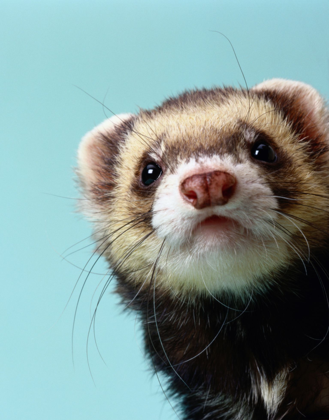

In [13]:
dest = Path('..', '__data', 'example-ferret.png')
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(420)

What a cute litte floofer! Now we'll collect our data for training - and remove the failed images.

In [15]:
searches = 'ferret','dragon'
path = Path('..', '__data', 'ferret_or_dragon')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server and blocking responses
    resize_images(path/o, max_size=400, dest=path/o)

/usr/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

I still need to write up a post about these *Data Block* objects since they're a good idea and might be able to generalize them beyond just Machine Learning.

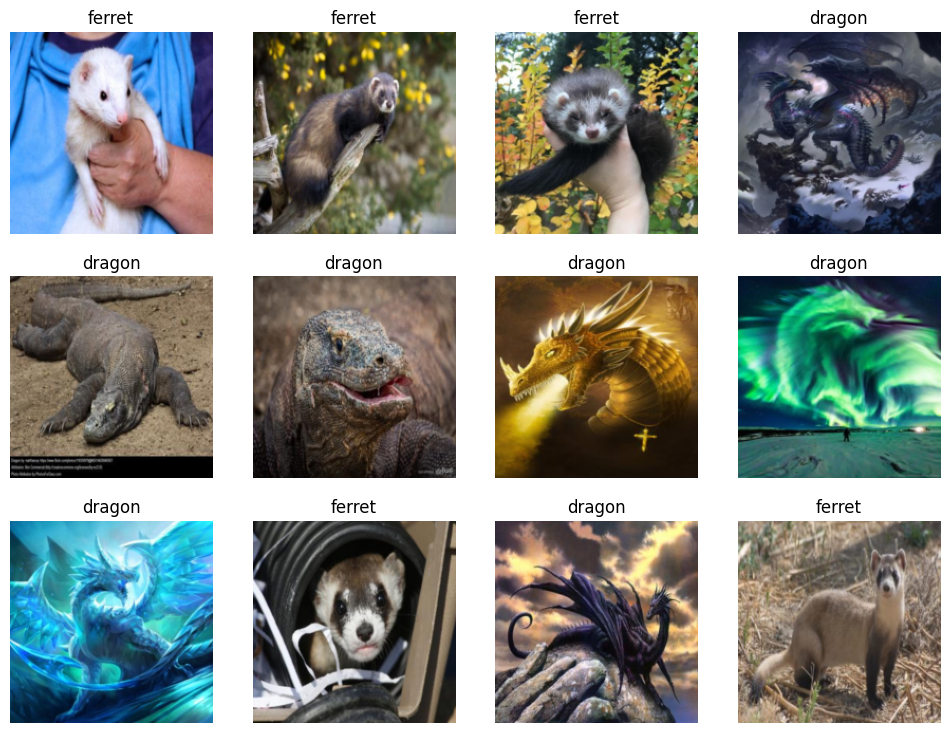

In [32]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=71),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

And, now the training!

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

/home/ranuse/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ranuse/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.740871,0.012448,0.000000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.084491,0.001599,0.000000,00:02
1,0.049812,0.000780,0.000000,00:02
2,0.032287,0.000196,0.000000,00:02
3,0.023381,0.000115,0.000000,00:02
4,0.018074,0.000076,0.000000,00:02
5,0.014552,0.000082,0.000000,00:02
6,0.012025,0.000100,0.000000,00:02


The model doing this well isn't surprising since the categories we've picked are intentionally distinct. After all, the point of this post is to show how simple this can be.

So, now we check to see if it is a **Floofer**.

In [33]:
is_ferret,_,probs = learn.predict(PILImage.create(Path('..', '__data', 'example-ferret.png')))
print(f"This is a: {is_ferret}.")
print(f"Probability it's a Floofer: {probs[1]:.4f}")

This is a: ferret.
Probability it's a Floofer: 1.0000


You may have caught there is a single difference in the code here. I changed the `probs[0]` to `probs[1]` to pull the probability. I'm not sure how or why it's returning like this but the probability tensor is reversed even though the category is correct. If I do the Dragon category as a example:

In [34]:
learn.predict(PILImage.create(Path('..', '__data', 'example-dragon.png')))

('dragon', TensorBase(0), TensorBase([1.0000e+00, 1.3599e-08]))

... then we see that the category is correct and the probability tensor for `Dragon` is now in index 0 instead of ferret. We can check the this under `learn.dls.vocab` and the `Dragon` category is in fact in index 0:

In [36]:
learn.dls.vocab

['dragon', 'ferret']

I would not of expected to need to check this for such a simple model but from now on I'll need to keep in mind the order. So, let's wright some code quick so we don't have to think about this again. We'll attach these together using a dictionary.

In [40]:
_,_,probs = learn.predict(PILImage.create(Path('..', '__data', 'example-dragon.png')))
dict(zip(learn.dls.vocab, probs))

{'dragon': TensorBase(1.), 'ferret': TensorBase(1.3599e-08)}

Using this now, we can simply ask for the probability based on the category we care about. Moving this a step forward, we can turn this into a function now for future use:

In [44]:
def paired_categories(learner, impath):
    _,_,probs = learner.predict(PILImage.create(impath))
    return dict(zip(learn.dls.vocab, probs))

In [46]:
pCats = paired_categories(learn, Path('..', '__data', 'example-dragon.png'))
pCats

{'dragon': TensorBase(1.), 'ferret': TensorBase(1.3599e-08)}

In [47]:
pCats['dragon']

TensorBase(1.)

# Conclusions

There we go! Now we have a model that can tell a floofy noodle from a scaley noodle!